In [1]:
import pandas as pd

In [2]:
# referebnce: https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=QxSMw0FrptiL

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
df = pd.read_csv('../data/can_train_stop.csv')
# val = pd.read_csv('../data/can_val.csv')

In [5]:
# df = pd.concat([train, val], axis=0)

In [6]:
# Get the lists of sentences and their labels.
sentences = df.TEXT.values
labels = df.LABEL.values

In [8]:
from transformers import BertTokenizer

print('Loading tokenizer...')

model_path = '../src/load_models/biodischarge'
tokenizer = BertTokenizer.from_pretrained(model_path, truncation=True)

Loading tokenizer...


In [9]:
# # Print the original sentence.
# print(' Original: ', sentences[0])

# # Print the sentence split into tokens.
# print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# # Print the sentence mapped to token ids.
# print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

In [10]:
# max_len = 0

# # For every sentence...
# for sent in sentences:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                return_attention_mask = True,
                truncation = True,
                return_tensors='pt'
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

In [12]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

In [13]:
# # Create a 90-10 train-validation split.

# # Calculate the number of samples to include in each set.
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size

# test = len(dataset) - train_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

train_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    model_path, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at ../src/load_models/biodischarge were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [16]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [17]:
# no_decay = ['bias', 'LayerNorm.weight']

# # Separate the `weight` parameters from the `bias` parameters. 
# # - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# # - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
# optimizer_grouped_parameters = [
#     # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.1},
    
#     # Filter for parameters which *do* include those.
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]

In [18]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
# total_steps = len(train_dataloader) * epochs

# # Create the learning rate scheduler.
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 25

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
#         scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables 
#     total_eval_accuracy = 0
#     total_eval_loss = 0
#     nb_eval_steps = 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:
        
#         # Unpack this training batch from our dataloader. 
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using 
#         # the `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids 
#         #   [1]: attention masks
#         #   [2]: labels 
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)
        
#         # Tell pytorch not to bother with constructing the compute graph during
#         # the forward pass, since this is only needed for backprop (training).
#         with torch.no_grad():        

#             # Forward pass, calculate logit predictions.
#             # token_type_ids is the same as the "segment ids", which 
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             result = model(b_input_ids, 
#                            token_type_ids=None, 
#                            attention_mask=b_input_mask,
#                            labels=b_labels,
#                            return_dict=True)

#         # Get the loss and "logits" output by the model. The "logits" are the 
#         # output values prior to applying an activation function like the 
#         # softmax.
#         loss = result.loss
#         logits = result.logits
            
#         # Accumulate the validation loss.
#         total_eval_loss += loss.item()

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()

#         # Calculate the accuracy for this batch of test sentences, and
#         # accumulate it over all batches.
#         total_eval_accuracy += flat_accuracy(logits, label_ids)
        

#     # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

#     # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)
    
#     # Measure how long the validation run took.
#     validation_time = format_time(time.time() - t0)
    
#     print("  Validation Loss: {0:.2f}".format(avg_val_loss))
#     print("  Validation took: {:}".format(validation_time))

#     # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
#             'Valid. Loss': avg_val_loss,
#             'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time
#             'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    106.    Elapsed: 0:13:04.
  Batch    80  of    106.    Elapsed: 0:26:16.

  Average training loss: 0.32
  Training epcoh took: 0:34:33

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    106.    Elapsed: 0:13:02.
  Batch    80  of    106.    Elapsed: 0:26:06.

  Average training loss: 0.22
  Training epcoh took: 0:34:23

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    106.    Elapsed: 0:13:06.
  Batch    80  of    106.    Elapsed: 0:26:16.

  Average training loss: 0.16
  Training epcoh took: 0:34:34

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    106.    Elapsed: 0:13:06.
  Batch    80  of    106.    Elapsed: 0:26:12.

  Average training loss: 0.15
  Training epcoh took: 0:34:29

Training complete!
Total training took 2:17:59 (h:mm:ss)


In [31]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,0.32,0:34:33
2,0.22,0:34:23
3,0.16,0:34:34
4,0.15,0:34:29


In [32]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Use plot styling from seaborn.
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
# plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
# plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# # Label the plot.
# plt.title("Training & Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.xticks([1, 2, 3, 4])

# plt.show()

#### testing on test set

In [33]:
test = pd.read_csv('../data/can_test_stop.csv')

In [26]:
sentences = test.TEXT.values
labels = test.LABEL.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(sent,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                return_attention_mask = True,
                truncation = True,
                return_tensors='pt'
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [27]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 188 test sentences...
    DONE.


In [28]:
print('Positive samples: %d of %d (%.2f%%)' % (test.LABEL.sum(), len(test.LABEL), (test.LABEL.sum() / len(test.LABEL) * 100.0)))

Positive samples: 18 of 188 (9.57%)


In [29]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
preds = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
labels = np.concatenate(true_labels, axis=0)



Testing accuracy 0.925531914893617

Testing f1 0.6666666666666666

Testing precision 0.5833333333333334

Testing recall 0.7777777777777778


[[ 14   4]
 [ 10 160]]


Testing Stats
True Ve | False Ne  | False Ve  | True Ne
  14    |     4     |    10     |   160  


              precision    recall  f1-score   support

           0       0.98      0.94      0.96       170
           1       0.58      0.78      0.67        18

    accuracy                           0.93       188
   macro avg       0.78      0.86      0.81       188
weighted avg       0.94      0.93      0.93       188



AUC: 0.8594771241830065


Total MCC: 0.634




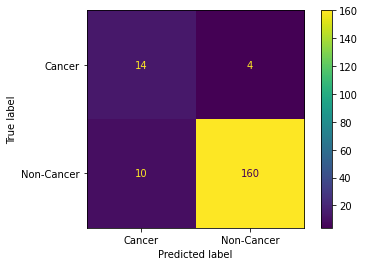

In [30]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'binary')

acc = accuracy_score(labels, preds)
print("\n")
print('Testing accuracy', acc)
print('\nTesting f1', f1)
print('\nTesting precision', precision)
print('\nTesting recall', recall)
print("\n")

cm = confusion_matrix(labels, preds, labels=[1, 0])
print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Cancer','Non-Cancer'])
cmd.plot()

print("\n")
print("Testing Stats")
tp, fn, fp, tn = cm.ravel()
print(f"{'True Ve':^7} | {'False Ne':^9} | {'False Ve':^9} | {'True Ne':^7}")
print(f"{tp :^7} | {fn :^9} | {fp :^9} | {tn :^7}")
print("\n")
print(classification_report(labels, preds))
print("\n")
v_auc = roc_auc_score(labels, preds)
print(f'AUC: {v_auc}')
print("\n")
mcc = matthews_corrcoef(labels, preds)
print('Total MCC: %.3f' % mcc)
print("\n")

In [34]:
### saving model:

In [35]:
model.save_pretrained('biodis_4ep_default_sp_st')

In [36]:
torch.save(model.state_dict(), 'biodis_4ep_default_st.pt')

In [33]:
# sda